Import libraries

In [93]:
import math
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.opflow import X, Y, Z, I, CircuitStateFn
from qiskit.visualization import plot_histogram
pi = math.pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.optimize import curve_fit
import re

Calculation of variational ground state energies $E_1$, $E_2$ and $E_3$ and fit for $E_N$

Lowest trial energy for N=1:  -0.4366 MeV
Lowest trial energy for N=2:  -1.7485 MeV
Lowest trial energy for N=3:  -2.0444 MeV


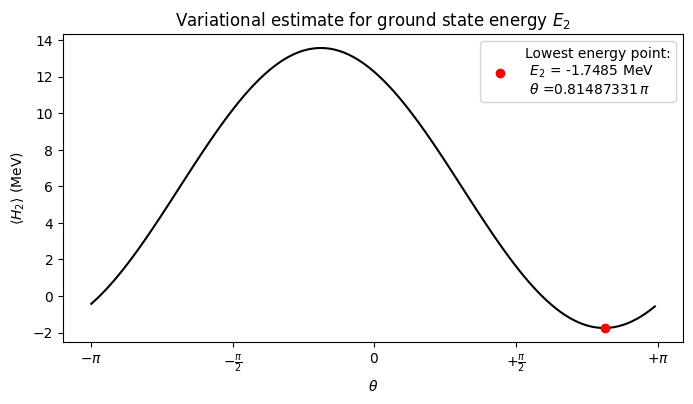

In [94]:
# Define deuterion Hamiltonian in the computational basis
Hamilt_1 = 0.218291 * (Z-I)
Hamilt_2 = (5.906709 * I^I) + (0.218291 * Z^I) - (6.125 * I^Z) - (2.143304 * X^X) - (2.143304 * Y^Y)
Hamilt_3 = (5.906709 * I^I^I) + (0.218291 * Z^I^I) - (6.125 * I^Z^I) - (2.143304 * X^X^I) - (2.143304 * Y^Y^I) +\
            + 9.625*(I^I^I) -9.625*(I^I^Z) - 3.913119*(I^X^X)  - 3.913119*(I^Y^Y)

# Deuteron parameters
m = 1875.612942 # MeV / c^2
hbar_c = 197.326980 # Mev fm

# The ground state for H_1 is obtained as <1|H_1|1>, no need to use variational method
state = Statevector.from_int(1,2)
E_1 =  state.expectation_value(Hamilt_1).real 

# Loop over variational parameter theta for calculation of <H_2>
theta = np.arange(-3.14,+3.14,0.05)
eta =  np.arange(-3.14,+3.14,0.05)
exp_val_2 = np.empty(len(theta))
exp_val_3 = np.empty((len(theta),len(eta)))
for kk in range(0, len(theta)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    circuit2 = QuantumCircuit(2)

    # Add X gate to qubit 0
    circuit2.x(0)

    # Rotation around y axis on qubit 1
    circuit2.ry(theta[kk], 1)

    # Add CNOT, control q1, target q0
    circuit2.cx(1,0)

    # Initialize state
    state2= Statevector.from_int(0, 4)

    # Evolve the state by the quantum circuit
    state2 = state2.evolve(circuit2)

    # Calculate expectation value
    exp_val_2[kk]=state2.expectation_value(Hamilt_2).real

    # loop over variational parameter eta for <H_3>
    for jj in range(0, len(eta)):
        # Create a Quantum Circuit acting on the q register, default all 3 qubits in the state |0>
        circuit3 = QuantumCircuit(3)

        # Add X gate to qubit 0
        circuit3.x(0)

        # Rotation around y axis on qubit 1
        circuit3.ry(eta[jj], 1)

        # Rotation around y axis on qubit 2
        circuit3.ry(theta[kk], 2)

        # Add CNOT, control q2, target q0
        circuit3.cx(2,0)

        # Add CNOT, control q0, target q1
        circuit3.cx(0,1)

        # Rotation around y axis on qubit 1
        circuit3.ry(-eta[jj], 1)

        # Add CNOT, control q0, target q1
        circuit3.cx(0,1)

        # Add CNOT, control q1, target q0
        circuit3.cx(1,0)

        # Initialize state
        state3= Statevector.from_int(0, 8)

        # Evolve the state by the quantum circuit
        state3 = state3.evolve(circuit3)

        # Calculate expectation value
        exp_val_3[kk, jj]=state3.expectation_value(Hamilt_3).real


# Lowest trial energy for <H_2> and <H_3>
E_2 = exp_val_2.min()
E_3 = exp_val_3.min()

# Draw the circuit
#circuit.draw('mpl')

# Plot of energy as a function of theta
# Plot style options
w = 8
h = 4
fontsize = 12
cmap = plt.get_cmap('tab20')
# <H_2>(theta)
lbl = 'Lowest energy point:\n $E_2$ = ' + str(round(E_2,4)) + ' MeV\n $\\theta$ =' + str(theta[np.where(exp_val_2 == E_2)]/pi).replace('[', '').replace(
    ']', '') + '$\,\\pi$'
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(111)
ax.plot(theta, exp_val_2, 'k')
unit = 0.5
x_tick = np.arange(-1, +1 + unit, unit)
x_label = [r'$-\pi $', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$']
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
plt.scatter(theta[np.where(exp_val_2 == E_2)], E_2, zorder= 5, color='red', label = lbl )
plt.legend()
plt.xlabel("$\\theta$")
plt.ylabel("$\\langle H_2 \\rangle$ (MeV)")
plt.title('Variational estimate for ground state energy $E_2$')
# Results
print('Lowest trial energy for N=1: ', round(E_1, 4), 'MeV')
print('Lowest trial energy for N=2: ', round(E_2, 4), 'MeV')
print('Lowest trial energy for N=3: ', round(E_3, 4), 'MeV')


Fit parameters [k gamma]= [ 0.43444621521969917 -14.29876545005959 ]
Infinite-basis extrapolated binding energy using h^2 k^2 / 2m:  -1.9592 MeV ( 11.7 % off)
Alternative result using finite size correction from E_3:  -2.0617 MeV ( 7.1 % off)


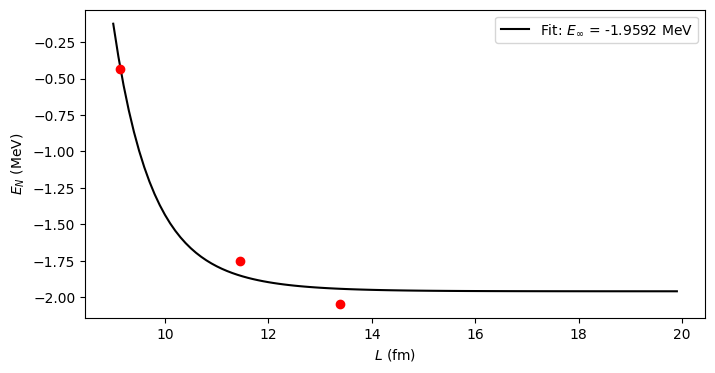

In [100]:
# List of trial energies
E_data = np.array([E_1, E_2, E_3])

# Effective hard-wall radius for N=1, N=2 & N=3
L = np.array([9.14, 11.45, 13.38])  # fm

# Harmonic oscillator variant of Lüscher formula
#   k: bound state momentum fm^(-1)
#   gamma: asymptotic normalization coefficient fm^(-1/2)
def luscher(l, k, gamma):
    return -hbar_c*hbar_c*k*k/(2*m)*(1 - 2*gamma*gamma*np.exp(-2*k*l)/k - 4*(gamma**4)*l*np.exp(-4*k*l)/k)
            #hbar_c*hbar_c*k*gamma*gamma*(1- gamma*gamma/k - (gamma**4)/(4*k*k) + 2*w*k*(gamma**4))*np.exp(-4*k*l)/m

# Fit to k and gamma
[k, gamma], cov = curve_fit(luscher, L, E_data)

# Fit plot
E_exact = -2.22 #MeV
ll = np.arange(9,20,0.1)
ee = luscher(ll, k, gamma)
lbl = 'Fit: $E_\infty$ = ' + str(round(-hbar_c*hbar_c*k*k/(2*m),4)) + ' MeV'
plt.figure(figsize=(w,h))
plt.plot(ll, ee, 'k', label= lbl)
plt.scatter(L, E_data, color = 'red', zorder=5)
plt.legend()
plt.xlabel('$L$ (fm)')
plt.ylabel('$E_N$ (MeV)')

# Results
E_gs_1 = -hbar_c*hbar_c*k*k/(2*m)
E_gs_2 = E_3 - hbar_c*hbar_c*k*k/(2*m)*( 2*gamma*gamma*np.exp(-2*k*L[2])/k + 4*(gamma**4)*L[2]*np.exp(-4*k*L[2])/k)
print('Fit parameters [k gamma]= [', k, gamma, ']')
print('Infinite-basis extrapolated binding energy using h^2 k^2 / 2m: ', round(E_gs_1,4), 'MeV (', round(np.abs(100*(E_exact -E_gs_1)/E_exact),1),'% off)' )
print('Alternative result using finite size correction from E_3: ', round(E_gs_2,4), 'MeV (', round(np.abs(100*(E_exact -E_gs_2)/E_exact),1),'% off)')